This notebook runs cross-validation for all clustering methods so we can compare them in one handy location. 

### imports

In [114]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt


import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.core.get_database as edb
from performance_eval import get_clf_metrics, cv_for_all_algs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load data

In [112]:
all_users = esta.TimeSeries.get_uuid_list()
confirmed_trip_df_map = {}
labeled_trip_df_map = {}
expanded_labeled_trip_df_map = {}
expanded_all_trip_df_map = {}
for u in all_users:
    ts = esta.TimeSeries.get_time_series(u)
    ct_df = ts.get_data_df("analysis/confirmed_trip")

    confirmed_trip_df_map[u] = ct_df
    labeled_trip_df_map[u] = esdtq.filter_labeled_trips(ct_df)
    expanded_labeled_trip_df_map[u] = esdtq.expand_userinputs(
        labeled_trip_df_map[u])
    expanded_all_trip_df_map[u] = esdtq.expand_userinputs(
        confirmed_trip_df_map[u])

### evaluate performance in aggregate

The following cell will load the cross-validation results for the listed models. (Parameters for the models being tested can be found in performance_eval.py)

If the cross-validation results for a model have already been generated, it will attempt to load it from the csv file to avoid the time-consuming process of re-running it. Otherwise, it will run the cross-validation from scratch. (This feature can be toggled with the override_prior_runs parameter - if True, it will ignore existing csv's and re-run from scratch.)

In [105]:
cv_results = cv_for_all_algs(
    uuid_list=all_users,
    expanded_trip_df_map=expanded_labeled_trip_df_map,
    model_names=[
        'old clustering', 'new clustering by combo r100m',
        'new clustering by end r100m', 'new clustering by trip r100m',
        'new clustering by combo r150m', 'new clustering by end r150m',
        'new clustering by trip r150m',
        'random forest with end and trip r150m',
        'random forest with end and trip r100m',
        'random forest with end and trip, drop unclustered r150m',
        'random forest with end r100m',
        'random forest with end and trip, drop unclustered r100m',
        'random forest with start and end r100m',
        'random forest with start end trip r100m', 'adaboost basic',
        'random forest, no clustering'
    ],
    override_prior_runs=False,
    raise_errors=False,
    random_state=42,
)


loading prior cross validation data for model: old clustering
loading prior cross validation data for model: new clustering by combo r100m
loading prior cross validation data for model: new clustering by end r100m
loading prior cross validation data for model: new clustering by trip r100m
loading prior cross validation data for model: new clustering by combo r150m
loading prior cross validation data for model: new clustering by end r150m
loading prior cross validation data for model: new clustering by trip r150m
loading prior cross validation data for model: random forest with end and trip r150m
loading prior cross validation data for model: random forest with end and trip r100m
loading prior cross validation data for model: random forest with end and trip, drop unclustered r150m
loading prior cross validation data for model: random forest with end r100m
loading prior cross validation data for model: random forest with end and trip, drop unclustered r100m
loading prior cross validation

In [106]:
# store results for all models in a nice dataframe
all_model_results = {
    ('model_name', ''): [],
    ('trips without prediction', 'mode'): [],
    ('trips without prediction', 'purpose'): [],
    ('trips without prediction', 'replaced'): [],
    ('accuracy overall', 'mode'): [],
    ('accuracy overall', 'purpose'): [],
    ('accuracy overall', 'replaced'): [],
    ('accuracy of trips w predictions', 'mode'): [],
    ('accuracy of trips w predictions', 'purpose'): [],
    ('accuracy of trips w predictions', 'replaced'): [],
    ('f1 weighted', 'mode'): [],
    ('f1 weighted', 'purpose'): [],
    ('f1 weighted', 'replaced'): [],
}

for model_name in cv_results.keys():
    print(f'now evaluating: {model_name}')
    all_model_results[('model_name', '')] += [model_name]
    for label_type in ['mode', 'purpose', 'replaced']:
        # get results
        results = get_clf_metrics(cv_results[model_name],
                                  label_type,
                                  keep_nopred=True,
                                  ignore_custom=False)

        # update our dict of aggregate results
        all_model_results[('trips without prediction', label_type)] += [
            results['n_trips_without_prediction']
        ]
        all_model_results[('accuracy overall',
                           label_type)] += [results['accuracy']]
        all_model_results[('accuracy of trips w predictions', label_type)] += [
            results['accuracy'] * len(results['label_true']) /
            (len(results['label_true']) -
             results['n_trips_without_prediction'])
        ]
        all_model_results[('f1 weighted',
                           label_type)] += [results['weighted_f_score']]

all_model_results_df = pd.DataFrame(all_model_results)
all_model_results_df


now evaluating: old clustering
now evaluating: new clustering by combo r100m
now evaluating: new clustering by end r100m
now evaluating: new clustering by trip r100m
now evaluating: new clustering by combo r150m
now evaluating: new clustering by end r150m
now evaluating: new clustering by trip r150m
now evaluating: random forest with end and trip r150m
now evaluating: random forest with end and trip r100m
now evaluating: random forest with end and trip, drop unclustered r150m
now evaluating: random forest with end r100m
now evaluating: random forest with end and trip, drop unclustered r100m
now evaluating: random forest with start and end r100m
now evaluating: random forest with start end trip r100m
now evaluating: adaboost basic
now evaluating: random forest, no clustering


model_name  \
                                                        
0                                      old clustering   
1                       new clustering by combo r100m   
2                         new clustering by end r100m   
3                        new clustering by trip r100m   
4                       new clustering by combo r150m   
5                         new clustering by end r150m   
6                        new clustering by trip r150m   
7               random forest with end and trip r150m   
8               random forest with end and trip r100m   
9   random forest with end and trip, drop uncluste...   
10                       random forest with end r100m   
11  random forest with end and trip, drop uncluste...   
12             random forest with start and end r100m   
13            random forest with start end trip r100m   
14                                     adaboost basic   
15                       random forest, no clustering   

   trips without prediction                  accuracy overall            \
                       mode purpose replaced             mode   purpose   
0                      2532    2512     2402         0.465158  0.454684   
1                      1626    1607     1555         0.489889  0.540335   
2                      1626    1607     1555         0.415325  0.481943   
3                      3652    3626     3492         0.365938  0.378442   
4                      1417    1398     1351         0.514926  0.555279   
5                      1417    1398     1351         0.430596  0.493981   
6                      3349    3324     3189         0.395240  0.401688   
7                         0       0        2         0.697070  0.651861   
8                         0       0        2         0.694593  0.645911   
9                      1411    1398     1339         0.574907  0.568562   
10                        0       0        2         0.688265  0.630552   
11                     1622    1607     1546         0.554272  0.547115   
12                        0       0        2         0.687577  0.640238   
13                        0       0        2         0.685651  0.644527   
14                        0       0        2         0.496630  0.410544   
15                        0       0        2         0.716605  0.664729   

             accuracy of trips w predictions                     f1 weighted  \
    replaced                            mode   purpose  replaced        mode   
0   0.423104                        0.712694  0.696925  0.641522    0.542336   
1   0.526293                        0.631047  0.694840  0.675091    0.538066   
2   0.475691                        0.534999  0.619751  0.610182    0.457220   
3   0.371226                        0.735416  0.759511  0.735055    0.468388   
4   0.546563                        0.639610  0.688454  0.676017    0.556381   
5   0.491708                        0.534860  0.612455  0.608170    0.466644   
6   0.397874                        0.732908  0.743787  0.726073    0.491833   
7   0.737349                        0.697070  0.651861  0.737558    0.687493   
8   0.736641                        0.694593  0.645911  0.736850    0.684271   
9   0.610206                        0.713383  0.704924  0.753149    0.624571   
10  0.728703                        0.688265  0.630552  0.728910    0.680624   
11  0.587385                        0.713476  0.703559  0.752224    0.611888   
12  0.730971                        0.687577  0.640238  0.731178    0.677362   
13  0.730120                        0.685651  0.644527  0.730328    0.674178   
14  0.569100                        0.496630  0.410544  0.569261    0.489146   
15  0.750957                        0.716605  0.664729  0.751170    0.708261   

                        
     purpose  replaced  
0   0.528051  0.484640  
1   0.581665  0.584200  
2   0.506330  0.523395  
3   0.477830  0.487683  
4   0.592000  0.597230  
5   0.512850  0.532052  
6   0.495934  0.508512  

### evaluate performance of different models against the size of each user's dataset

evaluate each algorithm's purpose prediction accuracy against the number of trips per user

In [ ]:
results_by_user = []

model_names = [
    'old clustering', 'new clustering by combo r100m',
    'new clustering by end r100m', 'new clustering by trip r100m',
    'new clustering by combo r150m', 'new clustering by end r150m',
    'new clustering by trip r150m', 'random forest with end and trip r150m',
    'random forest with end and trip r100m',
    'random forest with end and trip, drop unclustered r150m',
    'random forest with end r100m',
    'random forest with end and trip, drop unclustered r100m',
    'random forest with start and end r100m',
    'random forest with start end trip r100m', 'adaboost basic',
    'random forest, no clustering'
]

results_by_user = {
    ('', 'user_id') : [],
    ('', 'num_labeled_trips') : [],
}
# populate the dictionary
for model_name in model_names:
    results_by_user[('accuracy', model_name)] = []
for model_name in model_names:
    results_by_user[('f1 weighted',
                        model_name)] = []

for user in all_users:
    # user_metrics = {}
    results_by_user[('', 'user_id')] += [user]
    results_by_user[('', 'num_labeled_trips')] += [len(
        expanded_labeled_trip_df_map[user])]

    for model_name in model_names:
        cv_for_model = cv_results[model_name]

        if str(user) in cv_for_model.user_id.unique() and not all(cv_for_model.loc[cv_for_model.user_id == str(user),
                                    'purpose_pred'].isna()):
            results = get_clf_metrics(
                cv_for_model.loc[cv_for_model.user_id == str(user)],
                label_type='purpose',
                keep_nopred=True,
                ignore_custom=False)
            results_by_user[('accuracy', model_name)] += [results['accuracy']]
            results_by_user[('f1 weighted',
                          model_name)] += [results['weighted_f_score']]
        else:
            results_by_user[('accuracy', model_name)] += [np.nan]
            results_by_user[('f1 weighted',
                          model_name)] += [np.nan]

        # if user_metrics != {}:
        #     results_by_user += [user_metrics]

size_performance_df = pd.DataFrame(results_by_user)
size_performance_df

old clustering
new clustering by combo r150m
random forest with end and trip r150m
random forest, no clustering


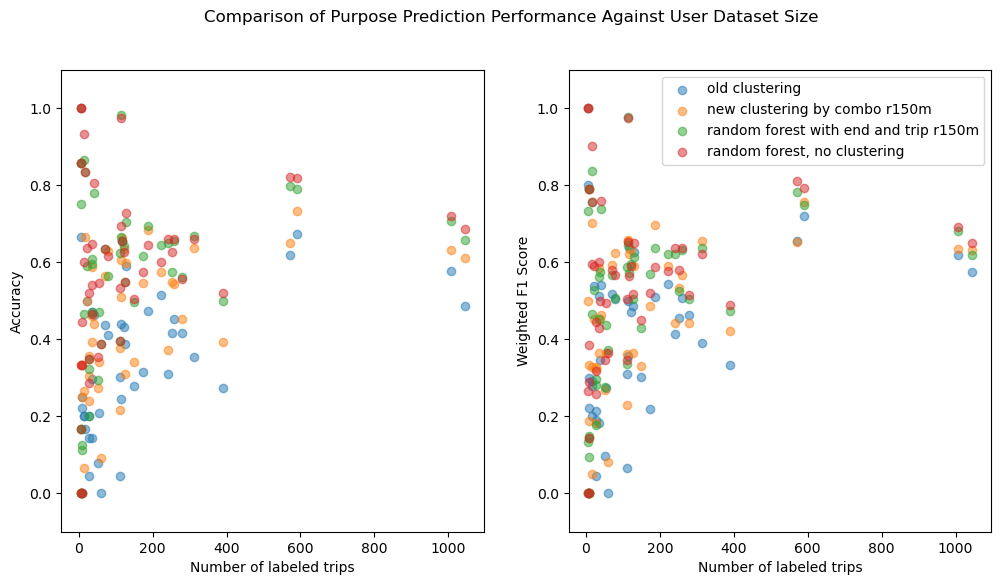

In [143]:
plt.style.use('default')

model_names = [
    'old clustering', 
    'new clustering by combo r150m', 'random forest with end and trip r150m',
    'random forest, no clustering'
]


fig, axs = plt.subplots(1, 2,
                        figsize=(12, 6),
                        sharex=True)
for i in range(len(model_names)):
    model_name = model_names[i]
    print(model_name)
    axs[0].scatter(size_performance_df[('', 'num_labeled_trips')],
                size_performance_df[('accuracy', model_name)], alpha=0.5, label=model_name)
    axs[1].scatter(size_performance_df[('', 'num_labeled_trips')],
                size_performance_df[('f1 weighted', model_name)], alpha=0.5, label=model_name)
axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Weighted F1 Score')
axs[0].set_ylim(-0.1, 1.1)
axs[1].set_ylim(-0.1, 1.1)

axs[0].set_xlabel('Number of labeled trips')
axs[1].set_xlabel('Number of labeled trips')

fig.suptitle('Comparison of Purpose Prediction Performance Against User Dataset Size')
axs[1].legend()
plt.show()